# 6.2 Regression

1. Load the Galton dataset into a Pandas dataframe?
    *  http://www.randomservices.org/random/data/Galton.html
    
2. Summarize the dataset:
    * Number of rows
    * Average height of male/female kids
    * Std deviation of male/female kids
    
3. Create a training and test dataset. The test dataset should be at least 25%.

4. Create 2 regression models: for predicting the childs height based on (i) father height and (ii) mother's height!

5. Compute the model quality parameters: $R^{2}$ and $MSE$! 

6. Create a multi-variate regression model including both the mother and father height as features! How does the $R^{2}$ change?

7. Create a Spark MLlib model for the same task!

References: 
* http://scikit-learn.org/stable/modules/linear_model.html
* http://scikit-learn.org/stable/model_selection.html
* <http:///pygot.wordpress.com/2017/03/25/simple-linear-regression-with-galton/>
* <https://spark.apache.org/docs/2.1.0/ml-classification-regression.html#linear-regression>

In [1]:
%matplotlib inline
import csv
import requests # pip install requests for easy http request for CSV data
import numpy as np
import pandas as pd

# 6.2.1 Load Data

In [32]:
df=pd.read_csv("http://www.randomservices.org/random/data/Galton.txt", sep="\t")

In [33]:
df.head()

,Family,Father,Mother,Gender,Height,Kids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4
3,1,78.5,67.0,F,69.0,4
4,2,75.5,66.5,M,73.5,4


In [34]:
df.describe()

,Father,Mother,Height,Kids
count,898.000000,898.000000,898.000000,898.000000
mean,69.232851,64.084410,66.760690,6.135857
std,2.470256,2.307025,3.582918,2.685156
min,62.000000,58.000000,56.000000,1.000000
25%,68.000000,63.000000,64.000000,4.000000
50%,69.000000,64.000000,66.500000,6.000000
75%,71.000000,65.500000,69.700000,8.000000
max,78.500000,70.500000,79.000000,15.000000


In [35]:
df_long=pd.melt(df, value_vars=["Father", "Mother"], 
        id_vars=["Height", "Kids", "Gender", "Family"],
        value_name="Parent_Height",
        var_name="Parent_Gender")

In [36]:
df_long.head(5)

,Height,Kids,Gender,Family,Parent_Gender,Parent_Height
0,73.2,4,M,1,Father,78.5
1,69.2,4,F,1,Father,78.5
2,69.0,4,F,1,Father,78.5
3,69.0,4,F,1,Father,78.5
4,73.5,4,M,2,Father,75.5


In [37]:
df.groupby("Gender").size()

Gender
F    433
M    465
dtype: int64

# 6.2.2 Regression Model

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [47]:
x=pd.Series(df['Father'])
y=pd.Series(df['Height'])
X = x[:,np.newaxis] 

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [49]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train,y_train) # X is row/col fmt, y is vector
print('Coefficient: \n', model.coef_)
print('Intercept: \n', model.intercept_)

Coefficient: 
 [0.4160534]
Intercept: 
 38.0258963696535


## 6.2.3 Model Validation

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
ypred_test = model.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test, ypred_test))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, ypred_test))

Mean squared error: 11.65
Variance score: 0.06


## 6.2.4 Plot

Make prediction

In [13]:
xpred = np.linspace(60, 80) # series of 50 (default) numbers between 60 and 80
Xpred = xpred[:, np.newaxis] # manipulate shape, add col dimension
ypred = model.predict(Xpred)

Plot

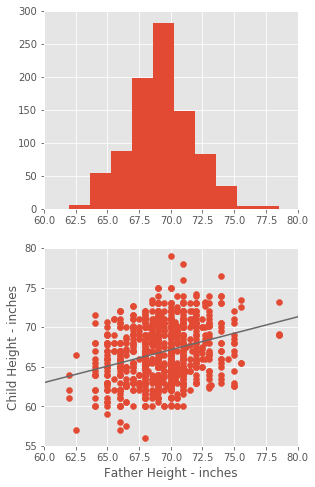

In [14]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
 
plt.figure(1, (10,8)) # 10 x 8 figure
 
# Histogram of x (Father height)
plt.subplot(2,2,1)
plt.hist(x)
plt.axis([60,80,0,300])
 
# Scatter plot with line-fit
plt.subplot(2,2,3)
plt.scatter(x,y)
plt.plot(Xpred,ypred, color="dimgrey")
plt.axis([60,80,55,80])
plt.xlabel("Father Height - inches")
plt.ylabel("Child Height - inches")
 
plt.show()

# 6.2.5 Multivariate Regression

In [53]:
X=df[["Father", "Mother"]].as_matrix()
y=pd.Series(df['Height'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = LinearRegression(fit_intercept=True)
model.fit(X_train,y_train) # X is row/col fmt, y is vector
print('Coefficient: \n', model.coef_)
print('Intercept: \n', model.intercept_)

Coefficient: 
 [0.41213461 0.27805953]
Intercept: 
 20.485586590605998


In [54]:
from sklearn.metrics import mean_squared_error, r2_score
ypred_test = model.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test, ypred_test))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, ypred_test))

Mean squared error: 11.26
R2 score: 0.09


# 6.2.6 Spark

In [58]:
%matplotlib inline
import os, sys
from sklearn import linear_model, datasets
import pandas as pd
import numpy as np
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [14]:
#SPARK_MASTER="local[1]"
SPARK_MASTER="spark://mpp3r01c04s02.cos.lrz.de:7077"
APP_NAME = "PySpark Lecture"
# If there is no SparkSession, create the environment
os.environ["PYSPARK_PYTHON"] = "/naslx/projects/pn69si/mnmda001/software/anaconda3/bin/python"

try:
    sc and spark
except NameError as e:
  #import findspark
  #findspark.init()
    import pyspark
    import pyspark.sql
    from pyspark.ml.feature import FeatureHasher
    from pyspark.ml.classification import LogisticRegression
    conf=pyspark.SparkConf().set("spark.cores.max", "4")
    sc = pyspark.SparkContext(master=SPARK_MASTER, conf=conf)
    spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initiated...")

PySpark initiated...


In [15]:
sdf=spark.createDataFrame(pd.read_csv("http://www.randomservices.org/random/data/Galton.txt", sep="\t"))

In [16]:
sdf.show()

+------+------+------+------+------+----+
|Family|Father|Mother|Gender|Height|Kids|
+------+------+------+------+------+----+
|     1|  78.5|  67.0|     M|  73.2|   4|
|     1|  78.5|  67.0|     F|  69.2|   4|
|     1|  78.5|  67.0|     F|  69.0|   4|
|     1|  78.5|  67.0|     F|  69.0|   4|
|     2|  75.5|  66.5|     M|  73.5|   4|
|     2|  75.5|  66.5|     M|  72.5|   4|
|     2|  75.5|  66.5|     F|  65.5|   4|
|     2|  75.5|  66.5|     F|  65.5|   4|
|     3|  75.0|  64.0|     M|  71.0|   2|
|     3|  75.0|  64.0|     F|  68.0|   2|
|     4|  75.0|  64.0|     M|  70.5|   5|
|     4|  75.0|  64.0|     M|  68.5|   5|
|     4|  75.0|  64.0|     F|  67.0|   5|
|     4|  75.0|  64.0|     F|  64.5|   5|
|     4|  75.0|  64.0|     F|  63.0|   5|
|     5|  75.0|  58.5|     M|  72.0|   6|
|     5|  75.0|  58.5|     M|  69.0|   6|
|     5|  75.0|  58.5|     M|  68.0|   6|
|     5|  75.0|  58.5|     F|  66.5|   6|
|     5|  75.0|  58.5|     F|  62.5|   6|
+------+------+------+------+-----

#### Feature Preparation

In [55]:
vecAssembler = VectorAssembler(inputCols=["Father", "Mother"], outputCol="features")
featurized = vecAssembler.transform(sdf)
data_train, data_test = featurized.randomSplit([0.75, 0.25], seed=12345)

#### Training

In [59]:
%%time
lr = LinearRegression(labelCol="Height", maxIter=100)

# Fit the model
lrModel = lr.fit(data_train)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R2: %f" % trainingSummary.r2)


Coefficients: [0.3731372039567139,0.2838950615489686]
Intercept: 22.733640427435965
numIterations: 1
RMSE: 3.395724
R2: 0.109395
CPU times: user 62.9 ms, sys: 20.8 ms, total: 83.7 ms
Wall time: 4.27 s


#### Model Prediction

Test Set for Computing Model Quality Metrics

In [62]:
predictions = lrModel.transform(data_test)
predictions.printSchema()

root
 |-- Family: string (nullable = true)
 |-- Father: double (nullable = true)
 |-- Mother: double (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Height: double (nullable = true)
 |-- Kids: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)

